In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from empyrical.stats import conditional_value_at_risk
import datetime

In [75]:
# load the data

#pd.set_option('display.max_rows', None)

rate_df = pd.read_csv("C:/Users/severusbot/Documents/AMS_517/Frechet_Model/EUR_USD_Historical_Data.csv")

rate_df = rate_df[['Date', 'Open', 'Price']]
rate_df['Date'] = pd.to_datetime(rate_df['Date'])
rate_df['Loss'] = rate_df['Price'] - rate_df['Open']
rate_df = rate_df[['Date', 'Loss']]

# find the max loss of each hour

rate_df.set_index('Date', inplace = True)

maxloss_df = rate_df.resample('W').max().dropna()
display(maxloss_df)

# check for NaN

maxloss_df.isnull().values.any()



,Loss
Date,
2000-04-09,-0.0034
2000-04-16,0.0095
2000-04-23,0.0002
2000-04-30,0.0027
2000-05-07,0.0059
...,...
2019-05-12,0.0028
2019-05-19,-0.0004
2019-05-26,0.0029


False

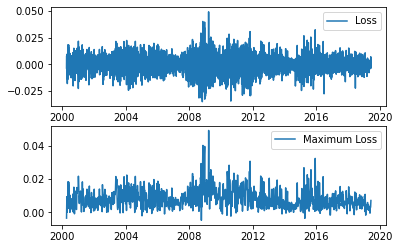

In [76]:
# plot loss data

fig,ax = plt.subplots(2,1)


ax[0].plot(rate_df['Loss'], label = 'Loss')
ax[1].plot(maxloss_df['Loss'], label = 'Maximum Loss')
ax[0].legend()
ax[1].legend()

In [77]:
# fit the frechet distribution using 500 data points

global_shape,global_loc,global_scale=invweibull.fit(maxloss_df['Loss'])
global_shape,global_loc,global_scale


C:\Users\severusbot\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(109.57010768236469, -0.4931504027328935, 0.49891630662557573)

No handles with labels found to put in legend.


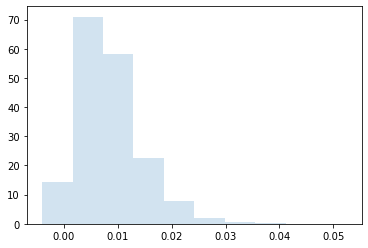

In [78]:
r = invweibull.rvs(global_shape,loc=global_loc,scale=global_scale, size=10000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

(array([ 7.95500796, 66.97006697, 63.08506309, 31.82003182, 11.28501129,
         2.22000222,  1.11000111,  0.18500019,  0.37000037,  0.18500019]),
 array([-0.0047,  0.0007,  0.0061,  0.0115,  0.0169,  0.0223,  0.0277,
         0.0331,  0.0385,  0.0439,  0.0493]),
 [<matplotlib.patches.Polygon at 0x16bee618340>])

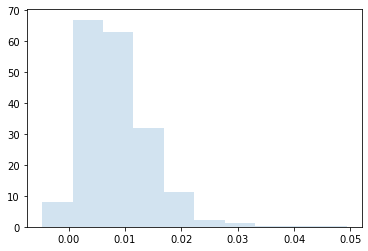

In [79]:
plt.hist(maxloss_df['Loss'], density=True, histtype='stepfilled', alpha=0.2)

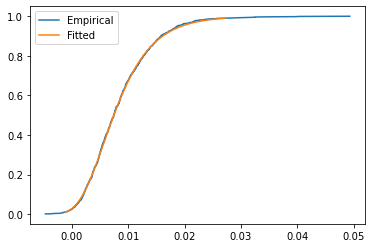

In [80]:
### Comparing Static distributions

ecdf=ECDF(maxloss_df['Loss'])
plt.plot(ecdf.x,ecdf.y,label='Empirical')

n=100
x = np.linspace(invweibull.ppf(0.01, global_shape,loc=global_loc,scale=global_scale),
                invweibull.ppf(0.99, global_shape,loc=global_loc,scale=global_scale), n)
frechet_cdf=invweibull.cdf(x,global_shape,loc=global_loc,scale=global_scale)
plt.plot(x,frechet_cdf,label='Fitted')
plt.legend()

In [81]:
# Time varying parameters

In [82]:
# we will use 250 samples

time_df = maxloss_df.copy()
time_df['Scale'] = np.nan
time_df['Shape'] = np.nan
time_df['Location'] = global_loc

def fit_invweibull(val):

    shape, loc, scale = invweibull.fit(val, floc = global_loc)
    return shape, loc, scale

for x in range(1, 251):
    time_df.iloc[250+x, 2], loc, time_df.iloc[250+x, 1] = fit_invweibull(maxloss_df['Loss'][:250+x])

time_df = time_df.bfill(axis = 'rows')
time_df = time_df.reset_index()

time_df

C:\Users\severusbot\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


,Date,Loss,Scale,Shape,Location
0,2000-04-09,-0.0034,0.499085,111.004663,-0.49315
1,2000-04-16,0.0095,0.499085,111.004663,-0.49315
2,2000-04-23,0.0002,0.499085,111.004663,-0.49315
3,2000-04-30,0.0027,0.499085,111.004663,-0.49315
4,2000-05-07,0.0059,0.499085,111.004663,-0.49315
...,...,...,...,...,...
996,2019-05-12,0.0028,NaN,NaN,-0.49315
997,2019-05-19,-0.0004,NaN,NaN,-0.49315
998,2019-05-26,0.0029,NaN,NaN,-0.49315
999,2019-06-02,0.0032,NaN,NaN,-0.49315


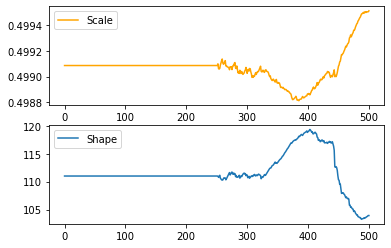

In [83]:
fig,ax = plt.subplots(2,1)

ax[1].plot(time_df['Shape'].values, label='Shape')
ax[0].plot(time_df['Scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()

In [84]:
# estimating coefficients using the training set
temp_df = time_df.copy()
temp_df = temp_df.dropna()

exog = -temp_df['Loss'][249:-1].values

mod = AutoReg(np.log(temp_df['Shape'][250:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
shape_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  251
Model:                   AutoReg-X(1)   Log Likelihood                1179.189
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Wed, 13 Apr 2022   AIC                            -12.239
Time:                        21:58:40   BIC                            -12.183
Sample:                             1   HQIC                           -12.217
                                  251                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2083      0.023     -9.084      0.000      -0.253      -0.163
y.L1           0.9971      0.003    288.301      0.000       0.990       1.004
x1             0.2239      0.020     11.225      0.0

C:\Users\severusbot\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


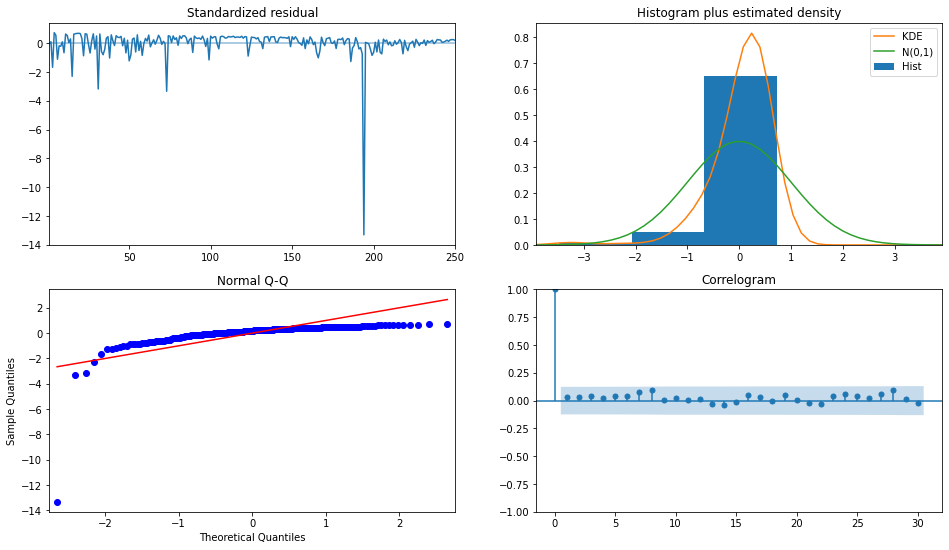

In [85]:
fig = plt.figure(figsize = (16, 9))
fig = res.plot_diagnostics(fig = fig, lags = 30)

In [86]:
exog = -temp_df['Loss'][224:-1].values

mod = AutoReg(np.log(temp_df['Scale'][225:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
scale_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  276
Model:                   AutoReg-X(1)   Log Likelihood                2673.844
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 13 Apr 2022   AIC                            -22.255
Time:                        21:58:40   BIC                            -22.202
Sample:                             1   HQIC                           -22.234
                                  276                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.002      0.131      0.896      -0.003       0.004
y.L1           0.9959      0.003    366.725      0.000       0.991       1.001
x1            -0.0031      0.000    -23.840      0.0

C:\Users\severusbot\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


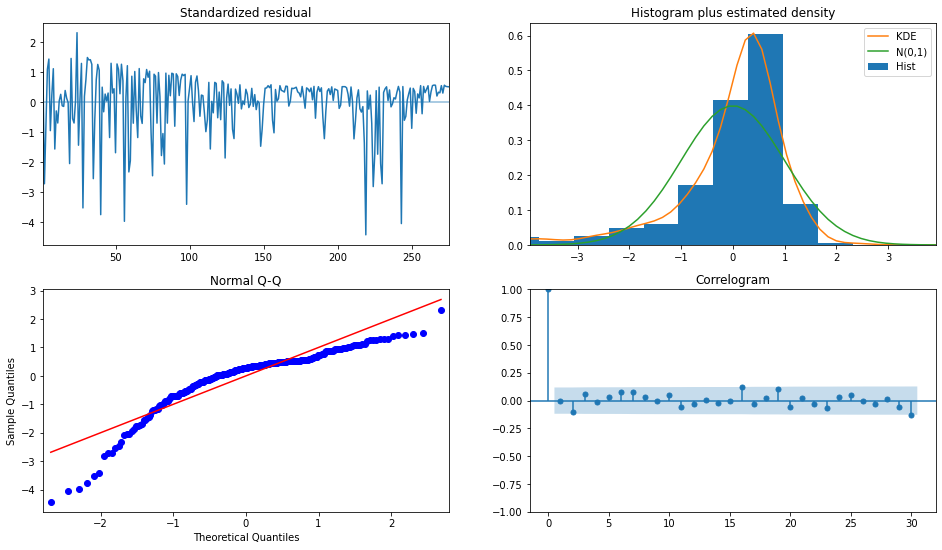

In [87]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [88]:
# Using the test data set

cvar1=pd.Series([])
cvar2=pd.Series([])
cvar3=pd.Series([])

counter = 0

for x,row in time_df.iterrows():
    if not np.isnan(row['Shape']) and not np.isnan(row['Scale']) :
        counter=counter+1
        cvar1=cvar1.append(pd.Series([np.nan],index=[x]))
        cvar2=cvar2.append(pd.Series([np.nan],index=[x]))
        cvar3=cvar3.append(pd.Series([np.nan],index=[x]))
        continue
        
    row['Shape']=np.exp(shape_params[0]+shape_params[1]*np.log(time_df['Shape'][counter-1])+shape_params[2]*np.exp(-time_df['Loss'][counter-1]) )# walk forward from our eqns
    row['Scale']=np.exp(scale_params[0]+scale_params[1]*np.log(time_df['Scale'][counter-1])+scale_params[2]*np.exp(-time_df['Loss'][counter-1]) )# walk forward 
    
    # empirical cvars for each fitted period outside of train set #1 
    cvar1=cvar1.append(pd.Series([1-conditional_value_at_risk(time_df['Loss'][:counter],0.1)],index=[x]))
    cvar2=cvar2.append(pd.Series([1-conditional_value_at_risk(time_df['Loss'][:counter],0.05)],index=[x]))
    cvar3=cvar3.append(pd.Series([1-conditional_value_at_risk(time_df['Loss'][:counter],0.01)],index=[x]))
    
    counter=counter+1
time_df['cvar_0.1']=cvar1
time_df['cvar_0.05']=cvar2
time_df['cvar_0.01']=cvar3
    
time_df

<ipython-input-88-2edd65cfa7f2>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar1=pd.Series([])
<ipython-input-88-2edd65cfa7f2>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar2=pd.Series([])
<ipython-input-88-2edd65cfa7f2>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar3=pd.Series([])


,Date,Loss,Scale,Shape,Location,cvar_0.1,cvar_0.05,cvar_0.01
0,2000-04-09,-0.0034,0.499085,111.004663,-0.49315,NaN,NaN,NaN
1,2000-04-16,0.0095,0.499085,111.004663,-0.49315,NaN,NaN,NaN
2,2000-04-23,0.0002,0.499085,111.004663,-0.49315,NaN,NaN,NaN
3,2000-04-30,0.0027,0.499085,111.004663,-0.49315,NaN,NaN,NaN
4,2000-05-07,0.0059,0.499085,111.004663,-0.49315,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
996,2019-05-12,0.0028,NaN,NaN,-0.49315,0.999368,1.000344,1.00234
997,2019-05-19,-0.0004,NaN,NaN,-0.49315,0.999368,1.000344,1.00234
998,2019-05-26,0.0029,NaN,NaN,-0.49315,0.999393,1.000370,1.00234
999,2019-06-02,0.0032,NaN,NaN,-0.49315,0.999393,1.000370,1.00234


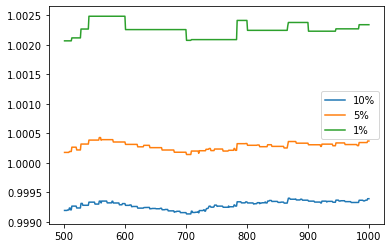

In [89]:
plt.plot(time_df['cvar_0.1'],label='10%')
plt.plot(time_df['cvar_0.05'],label='5%')
plt.plot(time_df['cvar_0.01'],label='1%')
plt.legend()

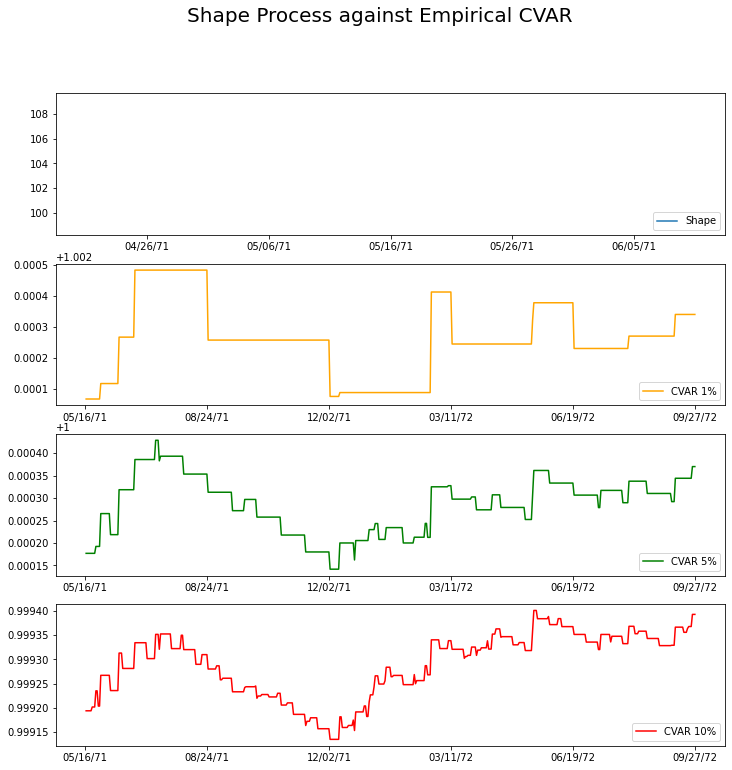

In [90]:
fig,ax = plt.subplots(4,1,figsize=(12,12))

fig.suptitle("Shape Process against Empirical CVAR",fontsize=20)

ax[0].plot(time_df['Shape'][500:], label='Shape')
ax[1].plot(time_df['cvar_0.01'][500:], label='CVAR 1%',color='orange') 
ax[2].plot(time_df['cvar_0.05'][500:], label='CVAR 5%',color='green') 
ax[3].plot(time_df['cvar_0.1'][500:], label='CVAR 10%',color='red') 
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))
ax[2].xaxis.set_major_formatter(DateFormatter("%D"))
ax[3].xaxis.set_major_formatter(DateFormatter("%D"))